In [67]:
import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

import numpy as np
import pandas as pd

from scipy.stats import zscore

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
uberdrives = pd.read_csv("Uber Drives - .csv")

uberdrives.columns = [i.split("*")[0].lower() for i in uberdrives.columns]

uberdrives.head()

,start_date,end_date,category,start,stop,miles,purpose
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [69]:
uberdrives.shape

(1156, 7)

In [70]:
uberdrives.isnull().sum() / uberdrives.shape[0] * 100

start_date     0.000000
end_date       0.086505
category       0.086505
start          0.086505
stop           0.086505
miles          0.000000
purpose       43.512111
dtype: float64

In [71]:
uberdrives.drop("purpose", axis=1, inplace=True)

In [72]:
uberdrives.dropna(subset=["end_date", "category", "start", "stop"], inplace=True)

In [73]:
for col in ["start_date", "end_date"]:
    uberdrives[col] = pd.to_datetime(uberdrives[col])

In [74]:
uberdrives.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1155 entries, 0 to 1154
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  1155 non-null   datetime64[ns]
 1   end_date    1155 non-null   datetime64[ns]
 2   category    1155 non-null   object        
 3   start       1155 non-null   object        
 4   stop        1155 non-null   object        
 5   miles       1155 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 63.2+ KB


In [75]:
uberdrives["start_day"] = uberdrives["start_date"].dt.day
uberdrives["start_month"] = uberdrives["start_date"].dt.month
uberdrives["start_year"] = uberdrives["start_date"].dt.year
uberdrives["start_hour"] = uberdrives["start_date"].dt.hour
uberdrives["start_minute"] = uberdrives["start_date"].dt.minute

uberdrives["end_day"] = uberdrives["end_date"].dt.day
uberdrives["end_month"] = uberdrives["end_date"].dt.month
uberdrives["end_year"] = uberdrives["end_date"].dt.year
uberdrives["end_hour"] = uberdrives["end_date"].dt.hour
uberdrives["end_minute"] = uberdrives["end_date"].dt.minute


uberdrives.drop(["start_date", "end_date"], axis=1, inplace=True)

In [76]:
uberdrives.nunique()

category          2
start           177
stop            188
miles           256
start_day        31
start_month      12
start_year        1
start_hour       23
start_minute     60
end_day          31
end_month        12
end_year          1
end_hour         24
end_minute       60
dtype: int64

In [77]:
uberdrives["start"] = uberdrives["start"].replace({'Kar?chi': "Karachi", "R?walpindi":"Rawalpindi"})
uberdrives["stop"] = uberdrives["stop"].replace({'Kar?chi': "Karachi", "R?walpindi":"Rawalpindi"})

In [78]:
for col in ["category", "start", "stop"]:
    uberdrives[col] = LabelEncoder().fit_transform(uberdrives[col])

In [79]:
X = pd.DataFrame(StandardScaler().fit_transform(uberdrives.drop("miles", axis=1)), columns=uberdrives.drop("miles", axis=1).columns)
y = uberdrives["miles"]

In [80]:
X = X.drop(["end_year", "start_year"], axis=1)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [82]:
xgb_reg = XGBRegressor()

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [121]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

## Machine Learning Explainability for XGBRegressor

In [165]:
xgb_explainer = shap.Explainer(lambda x: xgb_reg.predict(x), X_train)

shap_values_xgb = xgb_explainer(X_test)

PermutationExplainer explainer: 117it [00:42,  2.13it/s]                                                               


In [166]:
shap_values_xgb.shape

(116, 11)

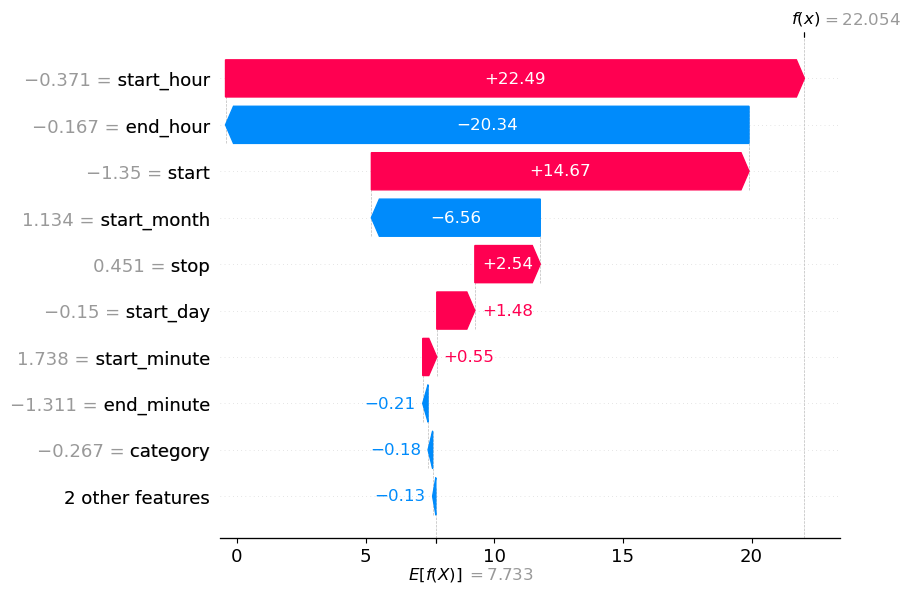

In [167]:
shap.plots.waterfall(shap_values_xgb[0])

In [168]:
shap.plots.force(shap_values_xgb[0])

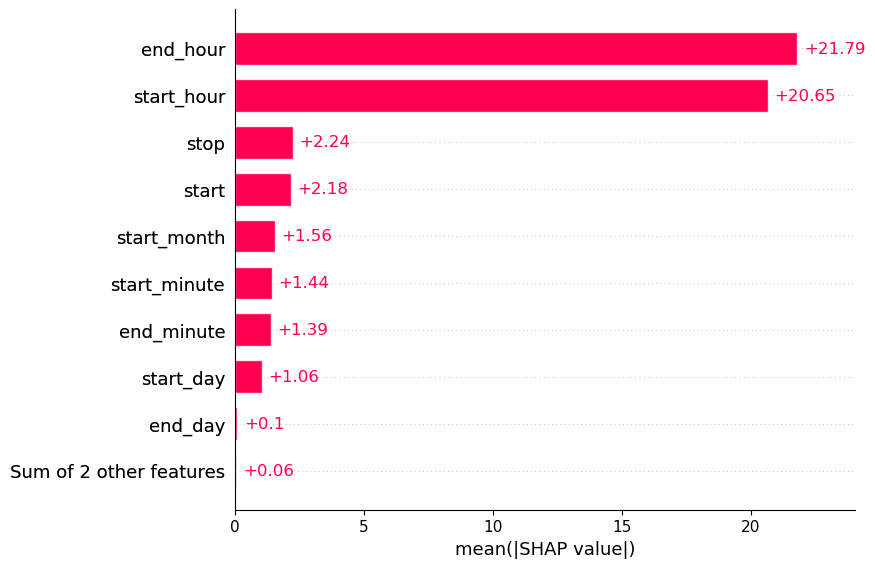

In [169]:
shap.plots.bar(shap_values_xgb)

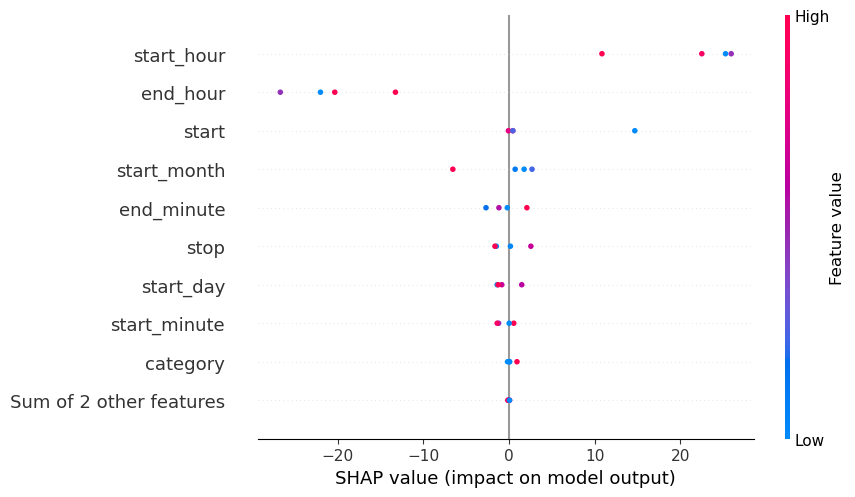

In [170]:
shap.plots.beeswarm(shap_values_xgb[:4])

## Machine Learning Explainability for LinearRegressor

In [181]:
lr_explainer = shap.Explainer(lambda x: lr.predict(x), X_train)

shap_value_lr = lr_explainer(X_test)

In [182]:
shap_value_lr.shape

(116, 11)

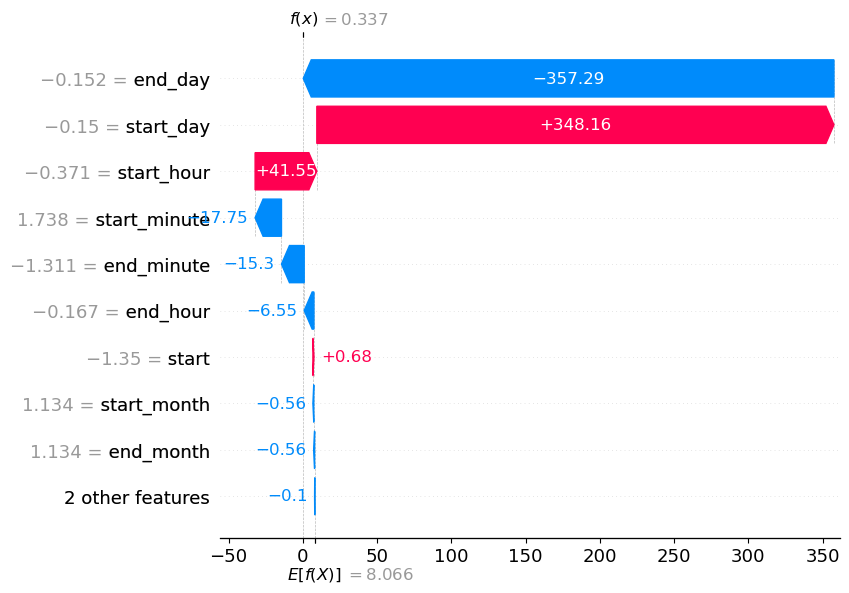

In [183]:
shap.plots.waterfall(shap_value_lr[0])

In [184]:
shap.plots.force(shap_value_lr[0])

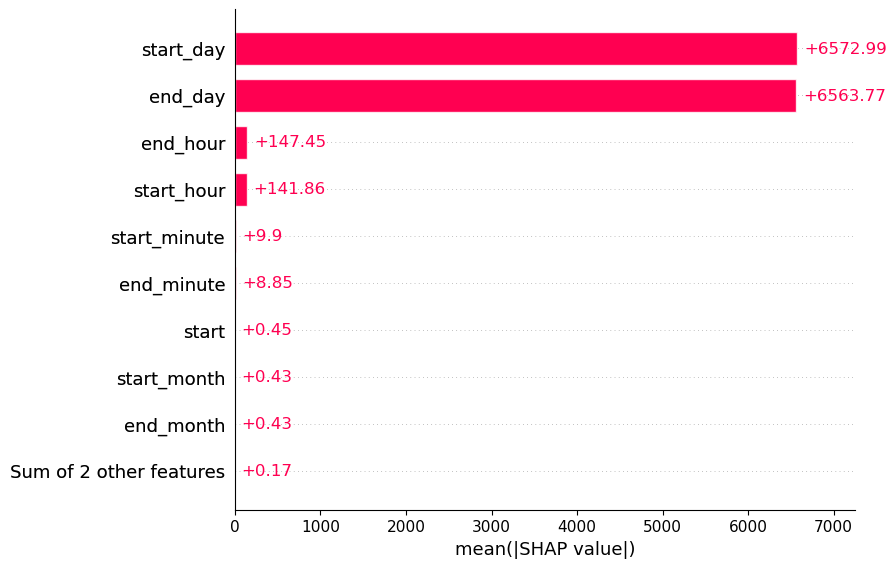

In [185]:
shap.plots.bar(shap_value_lr)

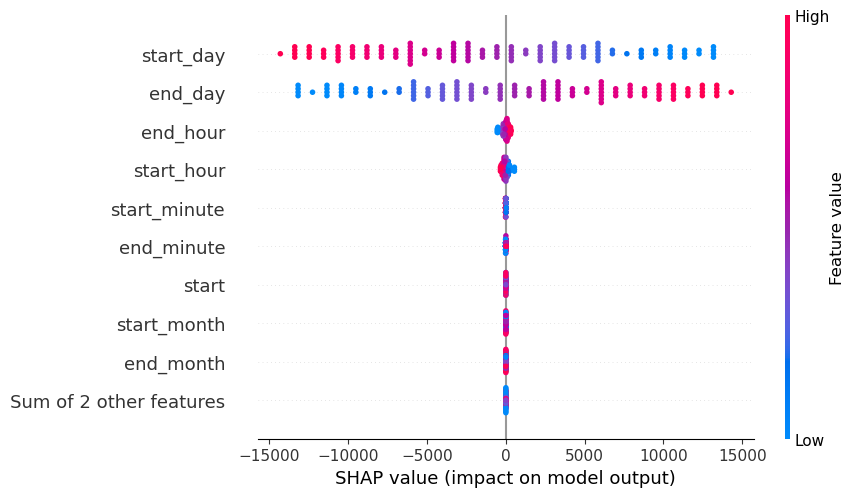

In [186]:
shap.plots.beeswarm(shap_value_lr)

# Eddy